<a href="https://colab.research.google.com/github/jake314jake/ChessFENDeepLearningPrediction/blob/main/ChessFENAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jakeamberson","key":"1695b811524bfe70d51bb55701d14ece"}'}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [9]:
!kaggle datasets download -d koryakinp/chess-positions

100% 4.01G/4.01G [04:31<00:00, 16.1MB/s]
100% 4.01G/4.01G [04:31<00:00, 15.8MB/s]


In [10]:
!unzip chess-positions.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/b1K5-6rB-5k2-5r2-1b6-8-5n2-8.jpeg  
  inflating: train/b1K5-8-3k4-3p4-8-3B1r2-1b6-4N3.jpeg  
  inflating: train/b1K5-8-8-2p3p1-5k2-8-8-7R.jpeg  
  inflating: train/b1K5-8-8-8-2qr1N2-8-6nk-3b4.jpeg  
  inflating: train/b1K5-r7-4kb2-R4Q1p-b7-1pb5-5P2-8.jpeg  
  inflating: train/b1KB4-2B5-3p4-1BB5-3k1n2-p1r5-2n5-5r1q.jpeg  
  inflating: train/b1Kb4-6P1-n2Q3k-8-4N1n1-2b2P2-8-8.jpeg  
  inflating: train/b1Kr4-8-q7-8-1bB5-8-2k1P1RR-8.jpeg  
  inflating: train/b1Kr4-P7-R2R4-1b3B2-3Pr3-4Nk2-8-4R3.jpeg  
  inflating: train/b1N1k3-K1q5-1P1B4-2R5-3N3Q-3brP2-8-1B1n4.jpeg  
  inflating: train/b1N1n1q1-R5RQ-1N2r2P-3n4-3k4-8-3n3N-K7.jpeg  
  inflating: train/b1N1qn2-1P5k-b3K1p1-8-2B4n-7N-5B2-1b2B3.jpeg  
  inflating: train/b1N1r1k1-2R5-1r2b3-5KpR-N1P5-8-6R1-7B.jpeg  
  inflating: train/b1N1r3-2P1r1k1-3b4-8-3K3b-2rB4-7p-8.jpeg  
  inflating: train/b1N2K1b-2Bp4-4B2k-b2p4-8-7n-3p3n-2B2B2.jpeg  
  inflating: train/b1N2b1R-3n4-P2P4-1n2K

[8, 9, 10]


In [80]:
train_size = 5000
test_size = 1500 #30/100
val_size=500     #10/100
train = glob.glob("/content/train/*.jpeg")
test = glob.glob("/content/test/*.jpeg")
shuffle(train)
shuffle(test)

train = train[:train_size]
test = test[:test_size]
val = train[-val_size:]
print(len(train))
print(len(test))
print(len(val))
piece_symbols = 'prbnkqPRBNKQ'

5000
1500
500


In [81]:
def fen_from_filename(filename):
  base = os.path.basename(filename)
  return os.path.splitext(base)[0]

In [13]:

print(fen_from_filename(train[0]))
print(fen_from_filename(test[0]))

4B3-1K3k2-P1p5-8-8-6B1-8-8
3K4-1P6-3b1k2-2pp4-5N1R-8-8-1N6


(-0.5, 399.5, 399.5, -0.5)

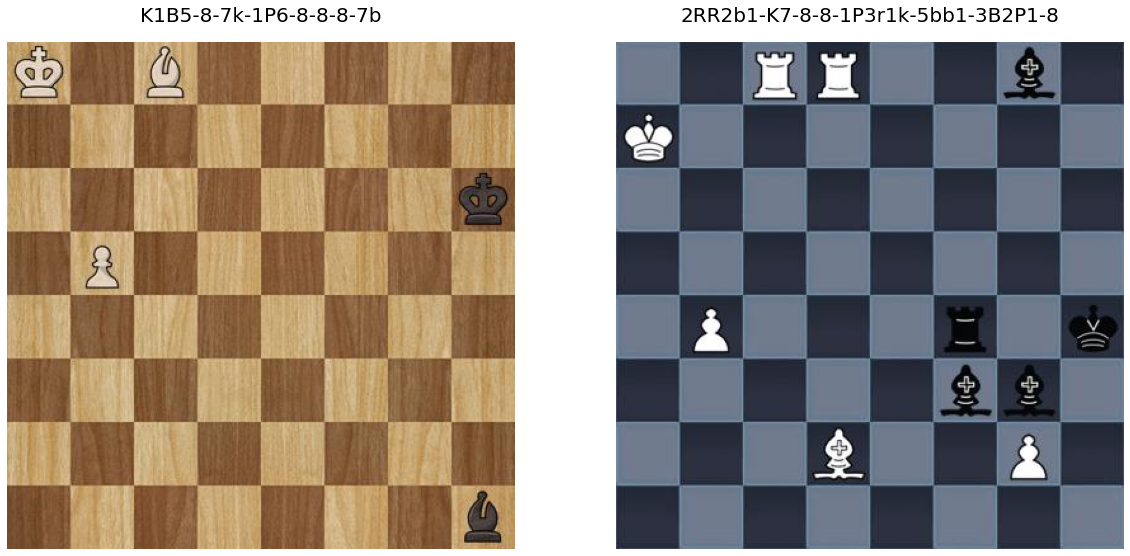

In [82]:
f, axarr = plt.subplots(1,2, figsize=(20, 30))


axarr[0].set_title(fen_from_filename(train[0]), fontsize=20, pad=20)
axarr[0].imshow(mpimg.imread(train[0]))
axarr[0].axis('off')

axarr[1].set_title(fen_from_filename(test[0]), fontsize=20, pad=20)
axarr[1].imshow(mpimg.imread(test[0]))
axarr[1].axis('off')



In [83]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [84]:
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

In [85]:
def Input_gen(features):
    for i, img in enumerate(features):
        y = onehot_from_fen(fen_from_filename(img))
        x = process_image(img)
        yield x, y


In [88]:
img_rows = 25
img_cols = 25

# Setup hyper parameters for deep learning
EPOCHS = 100
BATCH_SIZE = 32
VERBOSE = 1
NB_CLASSES = 13
VALIDATION_SPLIT = 0.1

In [89]:
model = Sequential()

In [90]:
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

In [91]:
# Add a convolutional layer
model.add(Convolution2D(15, kernel_size=2, activation='relu', 
                 input_shape=(img_rows, img_cols, 3)))


# Add a pooling operation
model.add(MaxPool2D(2))

# Add another convolutional layer
model.add(Convolution2D(5, kernel_size=2, activation='relu'))

# Flatten and feed to output layer
model.add(Flatten())
# Add a dropout layer
model.add(Dropout(0.3))
model.add(Dense(int(len(piece_symbols)+1), activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 24, 24, 15)        195       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 15)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 5)         305       
                                                                 
 flatten_4 (Flatten)         (None, 605)               0         
                                                                 
 dropout_4 (Dropout)         (None, 605)               0         
                                                                 
 dense_4 (Dense)             (None, 13)                7878      
                                                      

In [41]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


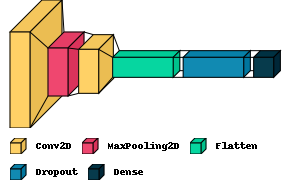

In [42]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [92]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [94]:
model.fit_generator(Input_gen(train),
                    steps_per_epoch=train_size//EPOCHS,
                    epochs=EPOCHS,
                    validation_data=Input_gen(val),
                    validation_steps=val_size//EPOCHS)
                    
                    

Epoch 1/100
50/50 [==============================] - 2s 31ms/step - loss: 1.0103 - accuracy: 0.8094 - val_loss: 0.8123 - val_accuracy: 0.8219
Epoch 2/100
50/50 [==============================] - 1s 29ms/step - loss: 0.7100 - accuracy: 0.8544 - val_loss: 0.7229 - val_accuracy: 0.8531
Epoch 3/100
50/50 [==============================] - 1s 30ms/step - loss: 0.5843 - accuracy: 0.8597 - val_loss: 0.4837 - val_accuracy: 0.8719
Epoch 4/100
50/50 [==============================] - 1s 29ms/step - loss: 0.4611 - accuracy: 0.8669 - val_loss: 0.3596 - val_accuracy: 0.9000
Epoch 5/100
50/50 [==============================] - 1s 27ms/step - loss: 0.3481 - accuracy: 0.8978 - val_loss: 0.4327 - val_accuracy: 0.8719
Epoch 6/100
50/50 [==============================] - 1s 28ms/step - loss: 0.3202 - accuracy: 0.9122 - val_loss: 0.2173 - val_accuracy: 0.9531
Epoch 7/100
50/50 [==============================] - 2s 33ms/step - loss: 0.2807 - accuracy: 0.9222 - val_loss: 0.2503 - val_accuracy: 0.9281
Epoch 

50/50 [==============================] - 1s 29ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 85/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0130 - accuracy: 0.9966
Epoch 86/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0169 - accuracy: 0.9962
Epoch 87/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0120 - accuracy: 0.9975
Epoch 88/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0140 - accuracy: 0.9953
Epoch 89/100
50/50 [==============================] - 1s 26ms/step - loss: 0.0144 - accuracy: 0.9956
Epoch 90/100
50/50 [==============================] - 1s 24ms/step - loss: 0.0098 - accuracy: 0.9978
Epoch 91/100
50/50 [==============================] - 1s 25ms/step - loss: 0.0168 - accuracy: 0.9953
Epoch 92/100
50/50 [==============================] - 1s 23ms/step - loss: 0.0071 - accuracy: 0.9981
Epoch 93/100
50/50 [==============================] - 1s 25ms/

In [95]:
res = (
  model.predict_generator(Input_gen(test), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)
res
print(type(res))

<class 'numpy.ndarray'>


In [96]:
res.shape

(1500, 8, 8)

In [97]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_filename(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.89600%


In [98]:
def display_with_predicted_fen(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

2/2 [==============================] - 0s 5ms/step


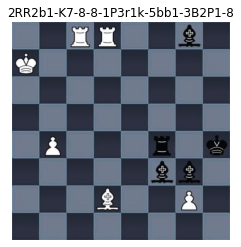

2RR2b1-K7-8-8-1P3r1k-5bb1-3B2P1-8
2/2 [==============================] - 0s 5ms/step


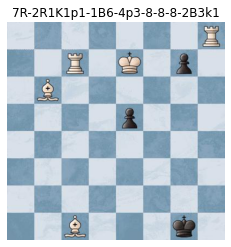

7R-2R1K1p1-1B6-4p3-8-8-8-2B3k1
2/2 [==============================] - 0s 8ms/step


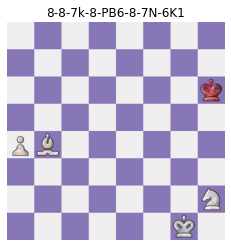

8-8-7k-8-PB6-8-7N-6K1


In [99]:
display_with_predicted_fen(test[0])
print(fen_from_filename(test[0]))
display_with_predicted_fen(test[1])
print(fen_from_filename(test[1]))
display_with_predicted_fen(test[2])
print(fen_from_filename(test[2]))